In [1]:
import PyKDL
import kdl_parser_py.urdf
import pickle
import torch
import sys, os
import cv2 as cv
import h5py
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import transformations as tf

import numpy as np

util_path = os.path.abspath("./utils/")
sys.path.append(util_path)
import transformation as trans
import projections as proj
np.set_printoptions(suppress=True)
%load_ext autoreload
%autoreload 2


In [3]:
act_path = "/home/zfei/code/act-plus-plus/"
sys.path.append(act_path)
from policy import ACTPolicy
from brl_constants import TASK_CONFIGS

ckpt_path = "/mnt/data1/act/train_act_scara_mag_fruit_block/mag_fruit_scratch/"
config_path = ckpt_path + "config.pkl"
# step = 500000
# policy_model_path = ckpt_path + "policy_step_%i_seed_0.ckpt"%step
policy_model_path = ckpt_path + "policy_step_50000_seed_0.ckpt"

stats_path = ckpt_path + "dataset_stats.pkl"

with open(config_path, "rb") as f:
    policy_config = pickle.load(f)['policy_config']
    print(policy_config)

policy = ACTPolicy(policy_config)
loading_status = policy.deserialize(torch.load(policy_model_path))

with open(stats_path, "rb") as f:
    stats = pickle.load(f)

pre_process_qpos = (
    lambda s_qpos: torch.from_numpy((s_qpos - stats["qpos_mean"]) / stats["qpos_std"])
    .float()
    .cuda()
    .unsqueeze(0)
)
post_process_action = lambda a: a * stats["action_std"] + stats["action_mean"]
BASE_DELAY = 13

print("loading ACT policy success")

{'lr': 1e-05, 'num_queries': 100, 'kl_weight': 10, 'hidden_dim': 512, 'dim_feedforward': 3200, 'lr_backbone': 1e-05, 'backbone': 'resnet18', 'enc_layers': 4, 'dec_layers': 7, 'nheads': 8, 'camera_names': ['wrist', 'wrist_down'], 'vq': False, 'vq_class': None, 'vq_dim': None, 'action_dim': 5, 'state_dim': 4, 'no_encoder': False}
ACT Args:  Namespace(lr=1e-05, lr_backbone=1e-05, batch_size=2, weight_decay=0.0001, epochs=300, lr_drop=200, clip_max_norm=0.1, backbone='resnet18', dilation=False, position_embedding='sine', camera_names=['wrist', 'wrist_down'], enc_layers=4, dec_layers=7, dim_feedforward=3200, hidden_dim=512, dropout=0.1, nheads=8, num_queries=100, pre_norm=False, masks=False, eval=False, onscreen_render=False, ckpt_dir='/mnt/data1/act/act_demo_z1_push_red/ckpt', policy_class='ACT', task_name='act_demo_z1_push_red', seed=0, num_steps=2000, kl_weight=10, chunk_size=None, temporal_agg=False, use_vq=False, vq=False, vq_class=None, vq_dim=None, load_pretrain=False, action_dim=5, 

In [4]:
def pre_proccess_img(img):
    img_torch = torch.from_numpy(img).unsqueeze(0)
    img_torch = torch.einsum("k h w c -> k c h w", img_torch)
    img_torch = (img_torch / 255.0).float().cuda().unsqueeze(0)
    return img_torch

In [7]:
h5data_file = "/mnt/data1/act/act_demo_scara_alldata/2024-04-15_05-06-27-mag-sb-block/episode_30.hdf5"
h5data_file = "/mnt/data1/act/act_demo_scara_alldata/2024-04-15_05-06-27-mag-sb-block/episode_37.hdf5"

index = 20
with torch.inference_mode():
    with h5py.File(h5data_file, "r") as root:
        qpos_np = root["/observations/qpos"][index]
        img_np = root["/observations/images/wrist"][index]
        print("img_np: ",img_np.shape)

        action_obs_np = root["action"][()]
        qpos = pre_process_qpos(qpos_np)
        qpos_all =  root["/observations/qpos"][()]
        curr_img = pre_proccess_img(img_np)
        # print("qpos: ",qpos.shape)
        print("curr_img: ",curr_img.shape)
        all_actions = policy(qpos, curr_img)
        all_actions = all_actions.squeeze(0).cpu().numpy()

        print("all_actions: ", all_actions.shape)
        print("action_obs_np: ", action_obs_np.shape)

        # actual_action = post_process_action(raw_action)
        # print("actual action %i"%index, actual_action)
action_obs_np = action_obs_np[index:]
qpos_all = np.asarray(qpos_all)
qpos_all = qpos_all[index:]


img_np:  (480, 640, 3)
curr_img:  torch.Size([1, 1, 3, 480, 640])


IndexError: index 1 is out of bounds for dimension 1 with size 1

In [ ]:
qpos_all.shape

(134, 4)

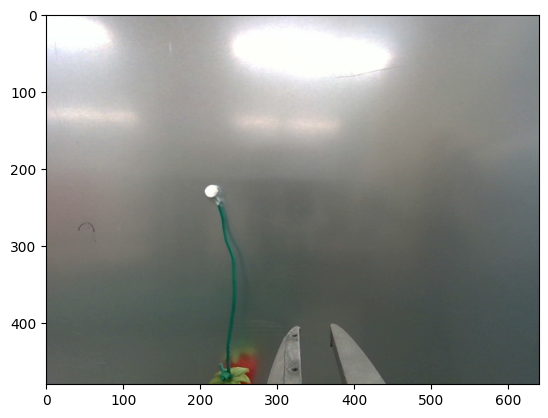

In [301]:
plt.imshow(cv.cvtColor(img_np, cv.COLOR_BGR2RGB))

In [302]:
joint_states_traj = []
actual_actions = []
for i, raw_action in enumerate(all_actions):
    actual_action = post_process_action(raw_action)
    actual_actions.append(actual_action)
actual_actions = np.asarray(actual_actions)
# print(actual_actions)

In [303]:
actual_action[:4]

array([-0.07310952, -0.3930364 , -1.1939954 ,  1.6686198 ], dtype=float32)

In [304]:
actual_action[4]

0.00046530506

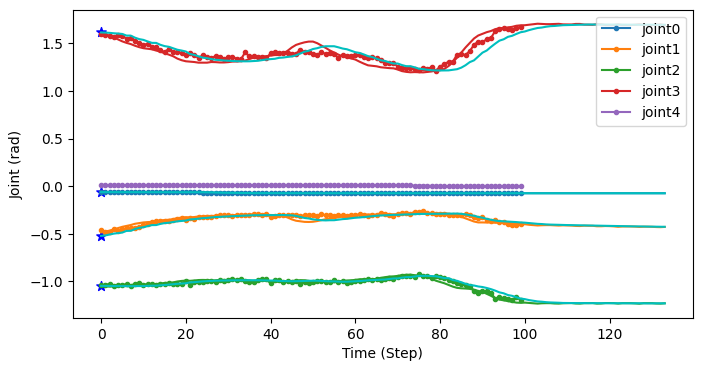

In [305]:
# plot all joint states and label them
plt.figure(figsize=(8, 4))
plt.plot(actual_actions[:, 0], marker=".", label='joint0')
plt.plot(actual_actions[:, 1], marker=".", label='joint1')
plt.plot(actual_actions[:, 2], marker=".", label='joint2')
plt.plot(actual_actions[:, 3], marker=".", label='joint3')
plt.plot(actual_actions[:, 4], marker=".", label='joint4')

plt.xlabel("Time (Step)")
plt.ylabel("Joint (rad)")
plt.legend()


plt.scatter(0, qpos_np[0], marker="*", c="b", s=50, label='joint0')
plt.scatter(0, qpos_np[1], marker="*", c="b", s=50, label='joint1')
plt.scatter(0, qpos_np[2], marker="*", c="b", s=50, label='joint2')
plt.scatter(0, qpos_np[3], marker="*", c="b", s=50, label='joint3')
# plt.plot(np.arange(0, len(qpos_gts), 1), qpos_gts, c="r", label='joint5')
steps_plot = np.arange(0, len(action_obs_np[:]), 1)
plt.plot(steps_plot, action_obs_np[:, 0],  c="C%i"%(0 ), label='joint0')
plt.plot(steps_plot, action_obs_np[:, 1],  c="C%i"%(1 ), label='joint1')
plt.plot(steps_plot, action_obs_np[:, 2],  c="C%i"%(2 ), label='joint2')
plt.plot(steps_plot, action_obs_np[:, 3],  c="C%i"%(3 ), label='joint3')

steps_plot = np.arange(0, len(qpos_all[:]), 1)
plt.plot(steps_plot, qpos_all[:, 0],  c="c", label='joint0')
plt.plot(steps_plot, qpos_all[:, 1],  c="c", label='joint1')
plt.plot(steps_plot, qpos_all[:, 2],  c="c", label='joint2')
plt.plot(steps_plot, qpos_all[:, 3],  c="c", label='joint3')

In [306]:
qpos_np

array([-0.0622736 , -0.52122337, -1.0459863 ,  1.612733  ], dtype=float32)

In [307]:
import PyKDL as kdl
import kdl_parser_py.urdf
import pickle
import torch
import sys, os
import cv2 as cv
import h5py
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import transformations as tf
from utils import robot_visualize as rbvis
import numpy as np
np.set_printoptions(suppress=True)

%load_ext autoreload
%autoreload 2



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [308]:
(ok, tree)  = kdl_parser_py.urdf.treeFromFile("./hitbot_model.urdf")
print("ok: ", ok)
tree


ok:  True


world(q_nr: 0)
 	body_link(q_nr: 0)
 	base_link(q_nr: 0)
 	link1(q_nr: 0)
 	link2(q_nr: 1)
 	link3(q_nr: 2)
 	link4(q_nr: 3)
 	camera_link(q_nr: 0)
 	
	ee_link(q_nr: 0)
 	
	
	
	
	
	
	
	

In [309]:
chain = tree.getChain("world", "camera_link")
fk_solver = kdl.ChainFkSolverPos_recursive(chain)


In [310]:

def plot_robot_2d_xy_batch(link_poses_list):
    """
    Plot the robot in 2d x-y space using matplotlib.
    """
    fig = plt.figure()
    ax = fig.add_subplot(111)

    for i, link_poses in enumerate(link_poses_list):
        # Loop over all poses
        prev_x, prev_y, prev_z = None, None, None
        for name, pose in link_poses:
            # Extract the x, y, and z coordinates from the pose
            x, y, z = pose.p[0], pose.p[1], pose.p[2]
            
            # Plot the point on the axes
            ax.scatter(x, y, c='r')
            
            # If it's not the first point, draw a line from the previous point to the current point
            if prev_x is not None:
                ax.plot([prev_x, x], [prev_y, y], c='r')
            prev_x, prev_y, prev_z = x, y, z
    ax.set_ylim([-0.5, 0.1])
    ax.set_xlim([-0.01, 0.6])

    # axis label
    ax.set_xlabel('X (m)')
    ax.set_ylabel('Y (m)')



In [311]:
len(action_obs_np)

134

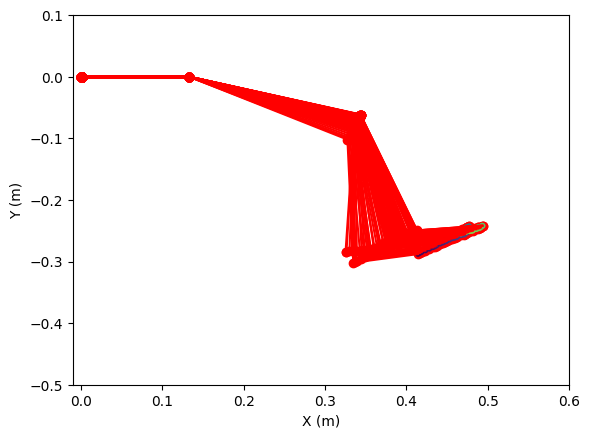

In [312]:
start_action_idx = 0
action_len = 100
link_poses_list = []
ee_poses = []
ee_poses_raw = []
for i in range(start_action_idx, start_action_idx+action_len, 1):
    action = action_obs_np[i]
    # action = actual_actions[i]

    joint_states = rbvis.joint_states_to_jnt_array(action[:4])
    link_poses = rbvis.get_poses(fk_solver, chain, joint_states)
    link_poses_list.append(link_poses)
    ee_poses.append([link_poses[-1][1].p[0], link_poses[-1][1].p[1], link_poses[-1][1].p[2]])
    ee_poses_raw.append(link_poses[-1][1])
plot_robot_2d_xy_batch(link_poses_list)
ee_poses = np.asarray(ee_poses)
plt.scatter(ee_poses[:, 0], ee_poses[:, 1], c=range(len(ee_poses)), marker='.')

# Display the plot
plt.show()

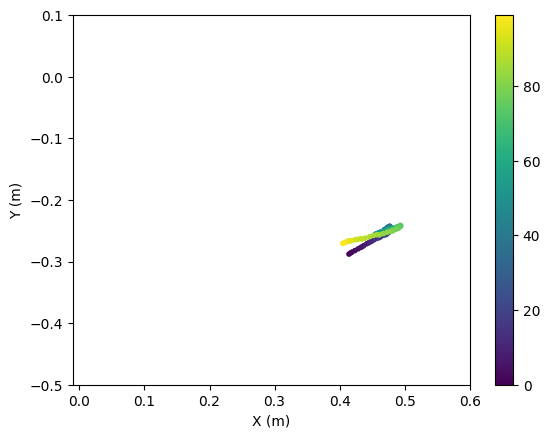

In [313]:
plt.scatter(ee_poses[:, 0], ee_poses[:, 1], c=range(len(ee_poses)), marker='.')
plt.ylim([-0.5, 0.1])
plt.xlim([-0.01, 0.6])
plt.xlabel('X (m)')
plt.ylabel('Y (m)')
plt.colorbar()

<Figure size 1000x800 with 0 Axes>

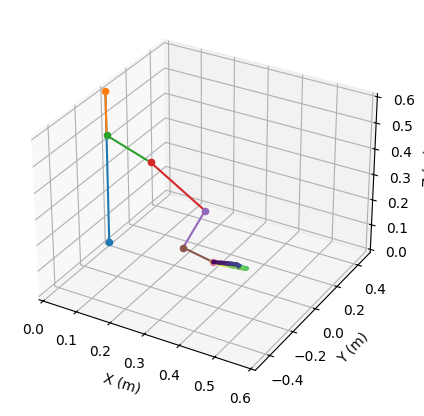

In [314]:
fig = plt.figure(figsize=(10, 8))
ax = rbvis.plot_robot(link_poses_list[0])

# plot ee_poses xyz
ax.scatter(ee_poses[:, 0], ee_poses[:, 1], ee_poses[:, 2], c=range(len(ee_poses)), marker='.')
ax.plot(ee_poses[:, 0], ee_poses[:, 1], ee_poses[:, 2], c='r')



ax.view_init(elev=30, azim=-60)  # Adjust viewpoint as needed

# Optional: Add grid and axes limits
ax.grid(True)
# Set appropriate limits based on your data range

plt.show() 

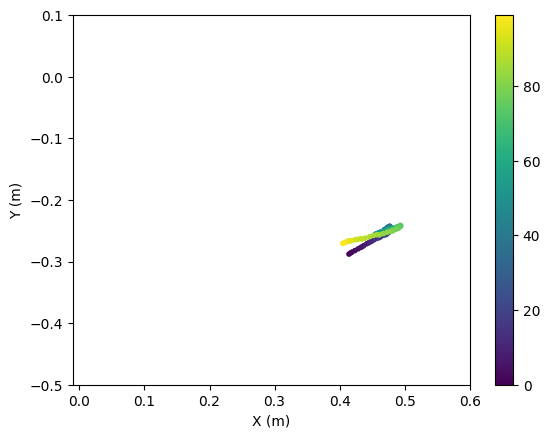

In [315]:
plt.scatter(ee_poses[:, 0], ee_poses[:, 1], c=range(len(ee_poses)), marker='.')
plt.ylim([-0.5, 0.1])
plt.xlim([-0.01, 0.6])
plt.xlabel('X (m)')
plt.ylabel('Y (m)')
plt.colorbar()

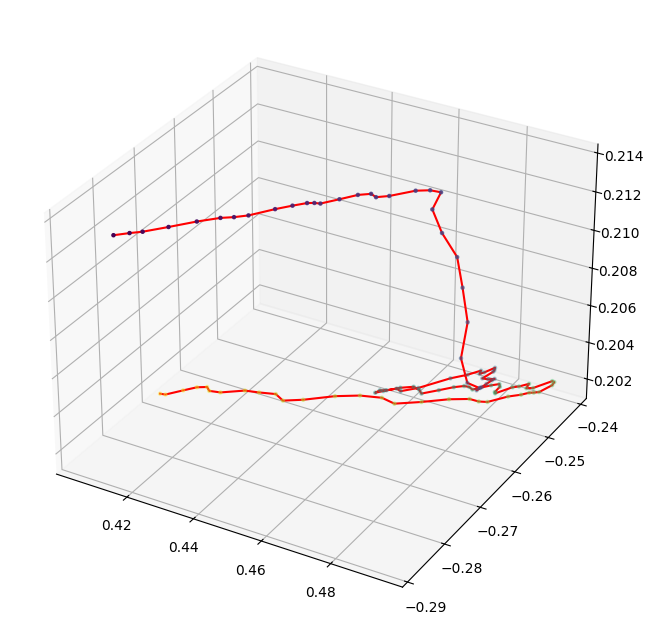

In [316]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
# plot ee_poses xyz
ax.scatter(ee_poses[:, 0], ee_poses[:, 1], ee_poses[:, 2], c=range(len(ee_poses)), marker='.')
ax.plot(ee_poses[:, 0], ee_poses[:, 1], ee_poses[:, 2], c='r')


# ax.set_ylim([-0.5, 0.5])
# ax.set_zlim([0, 0.3])
# ax.set_xlim([0, 0.6])

ax.view_init(elev=30, azim=-60)  # Adjust viewpoint as needed

# Optional: Add grid and axes limits
ax.grid(True)
# Set appropriate limits based on your data range

plt.show() 

# Image Projection

In [317]:
rgb_p = np.asarray([[429.76348876953125, 0.0, 321.4649658203125, 
                     0.0, 0.0, 429.129150390625, 242.32749938964844, 
                     0.0, 0.0, 0.0, 1.0, 0.0]]).reshape([3, 4])
rgb_p

array([[429.76348877,   0.        , 321.46496582,   0.        ],
       [  0.        , 429.12915039, 242.32749939,   0.        ],
       [  0.        ,   0.        ,   1.        ,   0.        ]])

In [318]:
def decode_frame_pose(frame_pose):
    position = [frame_pose.p.x(), frame_pose.p.y(), frame_pose.p.z()]
    orientation = [frame_pose.M.GetQuaternion()[0], frame_pose.M.GetQuaternion()[1],
                    frame_pose.M.GetQuaternion()[2], frame_pose.M.GetQuaternion()[3]]
    
    return position, orientation

In [332]:
transformation_matrix, rot_mat_ext, translation_mat= trans.kdl_frame_to_mat(ee_poses_raw[0])
transformation_matrix

array([[ 0.9980745 , -0.06202648, -0.00000046,  0.41440131],
       [ 0.06202648,  0.9980745 ,  0.00000733, -0.28793286],
       [ 0.        , -0.00000735,  1.        ,  0.21359574],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [321]:
pos_init, ori_quat_init = decode_frame_pose(ee_poses_raw[0])
ee_in_world_init = trans.vector_quat_to_matrix(pos_init, ori_quat_init)
ee_in_world_init
world_T_init = np.linalg.inv(ee_in_world_init)

In [322]:
transformation_matrix, rot_mat_ext, translation_mat= trans.kdl_frame_to_mat(ee_poses_raw[0])
ee_in_world_init = transformation_matrix
print("ee rpy: ", tf.euler_from_matrix(ee_in_world_init, 'rxyz'))
ee_in_world_init
world_T_init = np.linalg.inv(ee_in_world_init)

ee rpy:  (-7.332264723032965e-06, -4.556719315863092e-07, 0.06206631660294367)


In [323]:
world_T_init.dot(ee_in_world_init)

array([[ 1.,  0., -0., -0.],
       [ 0.,  1.,  0., -0.],
       [-0.,  0.,  1., -0.],
       [ 0.,  0.,  0.,  1.]])

In [324]:
ee_in_world_all = []
ee_in_init_all = []
ee_in_init_all_pos = []
ee_in_world_all_pos = []
for ee_pose in ee_poses_raw:
    ee_in_world_all_pos.append([ee_pose.p[0], ee_pose.p[1], ee_pose.p[2], 1])
    ee_in_world, _, _= trans.kdl_frame_to_mat(ee_pose)
    ee_in_world_all.append(ee_in_world)
    ee_in_init = world_T_init.dot(ee_in_world)
    ee_in_init_all.append(ee_in_init)
    ee_in_init_all_pos.append(ee_in_init[:3, 3])
    
    # print("ee rpy: ", tf.euler_from_matrix(ee_in_init, 'rxyz'))

ee_in_init_all_pos = np.asarray(ee_in_init_all_pos)
ee_in_world_all_pos = np.asarray(ee_in_world_all_pos)

In [325]:
pts_init = world_T_init.dot(ee_in_world_all_pos.T).T[:,: 3]


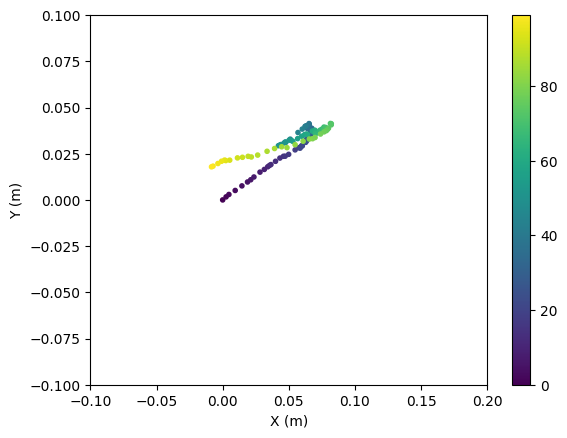

In [326]:
plt.scatter(ee_in_init_all_pos[:, 0], ee_in_init_all_pos[:, 1], c=range(len(ee_in_init_all_pos)), marker='.')
# plt.scatter(pts_init[:, 0], pts_init[:, 1], c=range(len(pts_init)), marker='.')
plt.ylim([-0.1, 0.1])
plt.xlim([-0.1, 0.2])
plt.xlabel('X (m)')
plt.ylabel('Y (m)')
plt.colorbar()

In [327]:
pts_ee = ee_in_init_all_pos.copy()
pts_ee[0]

array([-0., -0., -0.])

In [328]:
# camera_T_lidar = np.diag([1, 1, 1, 1])
camera_T_ee = trans.states2SE3([0.12, -0.008, -0.0485, 0, 0, 0])
# camera_T_ee = trans.states2SE3([0.12, -0.008, -0.05, 0, 0.2, -0.20])
# camera_T_ee = trans.states2SE3([0.1, 0, 0, 0, 0, 0])

pts_camera = camera_T_ee.dot(trans.xyz2homo(pts_ee).T).T[:,: 3]
pts_camera[0]
# pts_camera

array([ 0.12  , -0.008 , -0.0485])

In [329]:
pts_in_camera_opt = pts_camera.copy()
pts_in_camera_opt = pts_in_camera_opt[:, [1, 2, 0]]
pts_in_camera_opt[:, 2] = pts_in_camera_opt[:, 2]
pts_in_camera_opt[:, 0] = -pts_in_camera_opt[:, 0]
pts_in_camera_opt[:, 1] = -pts_in_camera_opt[:, 1]
pts_in_camera_opt[0]

array([0.008 , 0.0485, 0.12  ])

In [330]:
# uv = project_points_to_uv_batch(rgb_p, pts_optical)
uvs = proj.project_point_to_image(pts_in_camera_opt, rgb_p)


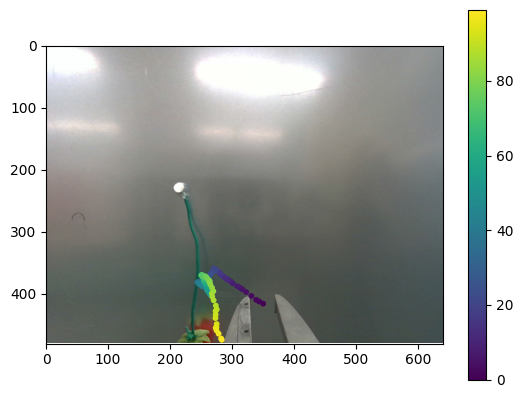

In [331]:
# with h5py.File(h5data_file, "r") as root:
#     img_np = root["/observations/images/wrist"][0]
# print("img_np: ",img_np.shape)
img_plot = img_np.copy()

plt.imshow(cv.cvtColor(img_np, cv.COLOR_BGR2RGB))
plt.scatter(uvs[:, 0], uvs[:, 1], c=range(len(uvs)), s=10)
# limit the axis to the image shape
plt.xlim([0, img_np.shape[1]])
plt.ylim([img_np.shape[0], 0])
plt.colorbar()